In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

### To repdict whether a person is looking for job change or not using demographics and relatable information

In [2]:
df = pd.read_csv("Zeta_Analytics Dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18359 entries, 0 to 18358
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18359 non-null  int64  
 1   city                    18359 non-null  object 
 2   city_development_index  18359 non-null  float64
 3   gender                  14261 non-null  object 
 4   relevent_experience     18359 non-null  object 
 5   enrolled_university     18017 non-null  object 
 6   education_level         17902 non-null  object 
 7   major_discipline        15521 non-null  object 
 8   experience              18300 non-null  object 
 9   company_size            13580 non-null  object 
 10  company_type            13320 non-null  object 
 11  last_new_job            17992 non-null  object 
 12  training_hours          18359 non-null  int64  
 13  target                  18359 non-null  int64  
dtypes: float64(1), int64(3), object(10)
me

## Data Preprocessing

In [3]:
df.drop(["city", "enrollee_id"], axis = 1, inplace = True)
# df["experience"] = df["experience"].astype("int")

In [4]:
cat_cols = df.select_dtypes("O").columns
num_cols = [col for col in df.columns if col not in cat_cols]
cat_na = [col for col in cat_cols if df[col].isnull().any()]
num_na = [col for col in num_cols if df[col].isnull().any()]

In [5]:
df[cat_na] = df[cat_na].fillna("NA")


In [6]:
map_company_size = {"50-99" : 3,
                    "100-500" : 4,
                    "10000+": 8,
                    "10/49  " : 2,
                    "1000-4999" : 6,
                    "<10" : 1  , 
                    "500-999"  : 5,
                    "5000-9999" : 7,
                    "NA": 0}
df["company_size"] = df["company_size"].map(map_company_size)

tx = ["experience","last_new_job"]
for col in tx:
    df[col] = df[col].astype("str").str.replace(">","").replace("<","").replace("never",0).replace("<1",0).replace("NA",-1)
    df[col] = df[col].astype("int")

In [7]:
df["education_level"].value_counts()
map_edu_levels = {"Primary School": 1,
                  "High School": 2,
                  "Graduate": 3,
                  "Masters": 4,
                  "Phd": 5,
                  "NA": 0}
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18359 entries, 0 to 18358
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  18359 non-null  float64
 1   gender                  18359 non-null  object 
 2   relevent_experience     18359 non-null  object 
 3   enrolled_university     18359 non-null  object 
 4   education_level         18359 non-null  object 
 5   major_discipline        18359 non-null  object 
 6   experience              18359 non-null  int32  
 7   company_size            16893 non-null  float64
 8   company_type            18359 non-null  object 
 9   last_new_job            18359 non-null  int32  
 10  training_hours          18359 non-null  int64  
 11  target                  18359 non-null  int64  
dtypes: float64(2), int32(2), int64(2), object(6)
memory usage: 1.5+ MB


### One hot encoding

In [8]:
df = pd.get_dummies(df, drop_first=True)

In [9]:
df.columns

Index(['city_development_index', 'experience', 'company_size', 'last_new_job',
       'training_hours', 'target', 'gender_Male', 'gender_NA', 'gender_Other',
       'relevent_experience_No relevent experience', 'enrolled_university_NA',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'education_level_High School',
       'education_level_Masters', 'education_level_NA', 'education_level_Phd',
       'education_level_Primary School', 'major_discipline_Business Degree',
       'major_discipline_Humanities', 'major_discipline_NA',
       'major_discipline_No Major', 'major_discipline_Other',
       'major_discipline_STEM', 'company_type_Funded Startup',
       'company_type_NA', 'company_type_NGO', 'company_type_Other',
       'company_type_Public Sector', 'company_type_Pvt Ltd'],
      dtype='object')

In [10]:
X = df.drop("target", axis = 1)
y = df["target"]

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [12]:
exp_median = df["experience"].median()
last_new_job_median = df["last_new_job"].median()
median_company_size = df["company_size"].median()
## inputing numeric null values after train test split to avoid data leakage
X_train["experience"]  = X_train["experience"].fillna(exp_median)
X_train["last_new_job"] = X_train["last_new_job"].fillna(last_new_job_median)
X_train["company_size"] = X_train["company_size"].fillna(median_company_size)
#test data
X_test["experience"]  = X_test["experience"].fillna(exp_median)
X_test["last_new_job"] = X_test["last_new_job"].fillna(last_new_job_median)
X_test["company_size"] = X_test["company_size"].fillna(median_company_size)

In [13]:
# Normalize data by scaling the train and test datasets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.values
y_test = y_test.values

In [14]:
df.target.value_counts()

0    15934
1     2425
Name: target, dtype: int64

### Define classes for our dataset and neural network

In [17]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Encapsulate out dataset as a class, which inherits from the torch Dataset class
class ChangeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [18]:
# Define the neural network Model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = nn.functional.relu(self.layer3(x))
        x = nn.functional.sigmoid(self.layer4(x))
        return x

In [19]:
import torch
# Convert numpy to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [20]:

def evaluate_and_train_nn_model(model, optimizer, batch_size = 128 , epochs = 25, print_every = 5):
    model.train() #setting model to train

    train_loss_list = []
    test_loss_list = []
    train_auc_list = []
    test_auc_list = [] #AUC score is used as evaluation metric as target data is imbalanced
    
    ##Convert tensor data into torch based objects
        # Convert the tensor based data to torch Dataset objects
    train_dataset = ChangeDataset(X_train_tensor, y_train_tensor)
    # Define torch data loader objects for these datasets
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = ChangeDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.BCELoss()

    # Train for the defined number of epochs
    for epoch in range(epochs):
        train_loss = 0.0
        for i, (features, labels) in enumerate(train_loader):
            optimizer.zero_grad() # Clear the gradients of all optimized variables
            outputs = model(features) # pass our data(input features) through the model
            loss = criterion(outputs.squeeze(), labels) # calculate the loss between model outputs and expected labels
            loss.backward() # Backward pass: compute the gradient of the loss with respect to model parameters
            optimizer.step() # Perform a single optimization step (parameter update)
            train_loss += loss.item() # Accumulate the training loss to later calculate the average
        
        # Calculate the average training loss for current epoch
        train_loss = train_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Evaluate on test set
        model.eval() # Switch model to evaluation mode


        
        test_loss = 0.0
        # Disable gradient calculation for evaluation to save memory and computations
        with torch.no_grad():
            # Iterate over the test dataset
            for features, labels in test_loader:
                outputs = model(features) # Forward pass: compute the output of the model by passing the input features
                loss = criterion(outputs.squeeze(), labels) # Calculate the loss between the model output and expected labels
                test_loss += loss.item() # Accumulate the test loss to later calculate the average
            train_auc = roc_auc_score(y_train_tensor, model(X_train_tensor))
            test_auc = roc_auc_score(y_test_tensor, model(X_test_tensor))
        
        # Calculate test loss for epoch
        test_loss = test_loss / len(test_loader)
        test_loss_list.append(test_loss)

        # Print losses
        if (epoch + 1) % print_every == 0:
            print(f'Epoch {epoch+1}/{epochs},Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Auc: {train_auc:.4f}, Test Auc: {test_auc:.4f}')

    plt.plot(range(epochs),train_loss_list, label = 'train')
    plt.plot(range(epochs),test_loss_list, label = 'test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

Epoch 10/100,Train Loss: 0.3737, Test Loss: 0.3852, Train Auc: 0.6473, Test Auc: 0.6353
Epoch 20/100,Train Loss: 0.3703, Test Loss: 0.3831, Train Auc: 0.6623, Test Auc: 0.6455
Epoch 30/100,Train Loss: 0.3682, Test Loss: 0.3826, Train Auc: 0.6709, Test Auc: 0.6448
Epoch 40/100,Train Loss: 0.3663, Test Loss: 0.3826, Train Auc: 0.6794, Test Auc: 0.6456
Epoch 50/100,Train Loss: 0.3641, Test Loss: 0.3826, Train Auc: 0.6880, Test Auc: 0.6477
Epoch 60/100,Train Loss: 0.3617, Test Loss: 0.3822, Train Auc: 0.6987, Test Auc: 0.6514
Epoch 70/100,Train Loss: 0.3593, Test Loss: 0.3828, Train Auc: 0.7105, Test Auc: 0.6506
Epoch 80/100,Train Loss: 0.3550, Test Loss: 0.3893, Train Auc: 0.7199, Test Auc: 0.6436
Epoch 90/100,Train Loss: 0.3530, Test Loss: 0.3891, Train Auc: 0.7279, Test Auc: 0.6459
Epoch 100/100,Train Loss: 0.3487, Test Loss: 0.3888, Train Auc: 0.7453, Test Auc: 0.6397


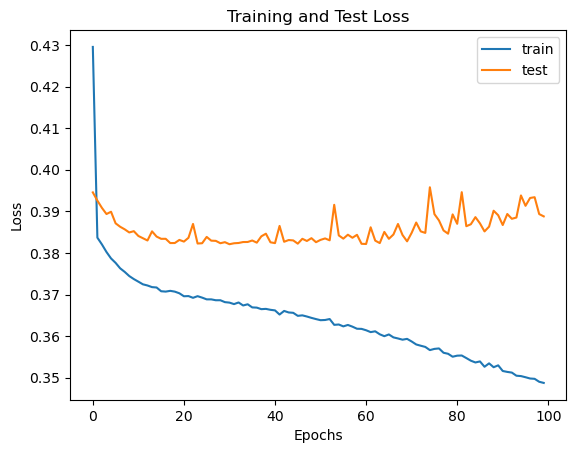

In [21]:
# We have to create a new model class here due the pass-by-reference feature of python functions
model = BinaryClassifier()
# Initialize SGD optimizer
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# Train using optimizer_sgd
evaluate_and_train_nn_model(model, optimizer = opt, epochs=100, print_every=10)

Epoch 10/100,Train Loss: 0.3630, Test Loss: 0.3847, Train Auc: 0.6997, Test Auc: 0.6420
Epoch 20/100,Train Loss: 0.3462, Test Loss: 0.4048, Train Auc: 0.7381, Test Auc: 0.6211
Epoch 30/100,Train Loss: 0.3285, Test Loss: 0.4498, Train Auc: 0.7762, Test Auc: 0.5948
Epoch 40/100,Train Loss: 0.3071, Test Loss: 0.5042, Train Auc: 0.8156, Test Auc: 0.5819
Epoch 50/100,Train Loss: 0.2860, Test Loss: 0.6072, Train Auc: 0.8462, Test Auc: 0.5657
Epoch 60/100,Train Loss: 0.2602, Test Loss: 0.7206, Train Auc: 0.8723, Test Auc: 0.5508
Epoch 70/100,Train Loss: 0.2406, Test Loss: 0.8388, Train Auc: 0.8970, Test Auc: 0.5401
Epoch 80/100,Train Loss: 0.2276, Test Loss: 0.9202, Train Auc: 0.9088, Test Auc: 0.5336
Epoch 90/100,Train Loss: 0.2104, Test Loss: 1.1262, Train Auc: 0.9205, Test Auc: 0.5355
Epoch 100/100,Train Loss: 0.2113, Test Loss: 1.2071, Train Auc: 0.9263, Test Auc: 0.5261


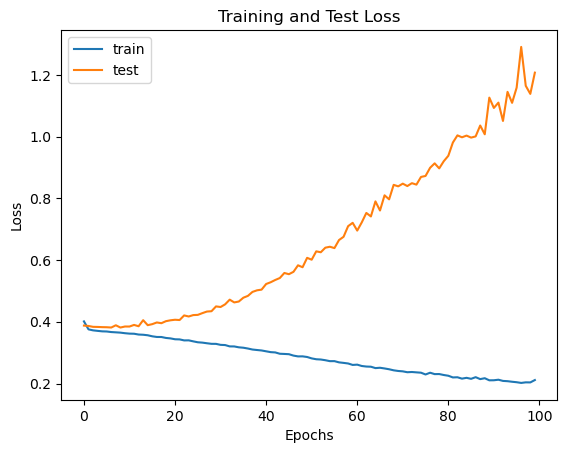

In [22]:
model = BinaryClassifier()
# Initialize SGD optimizer
opt = optim.Adam(model.parameters())
# Train using optimizer_sgd
evaluate_and_train_nn_model(model, opt, epochs=100, print_every=10)